We import all the necessary packages. Most of these have already been explained before. The new ones are combinations and factorial, which we use in the Best Subset Selection algorithm

In [0]:
import numpy as np   
import statsmodels.api as sm
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import combinations
from math import factorial

plt.style.use('ggplot')

import io
from google.colab import files

This dataset was taken from https://www.kaggle.com/karangadiya/fifa19.

In [0]:
uploaded = files.upload()

Saving data.csv to data.csv


In [0]:
csv_file = io.BytesIO(uploaded['data.csv'])
fifa_df = pd.read_csv(csv_file)
print(fifa_df.head(10))

   Unnamed: 0      ID  ... GKReflexes  Release Clause
0           0  158023  ...        8.0         €226.5M
1           1   20801  ...       11.0         €127.1M
2           2  190871  ...       11.0         €228.1M
3           3  193080  ...       94.0         €138.6M
4           4  192985  ...       13.0         €196.4M
5           5  183277  ...        8.0         €172.1M
6           6  177003  ...        9.0         €137.4M
7           7  176580  ...       37.0           €164M
8           8  155862  ...       11.0         €104.6M
9           9  200389  ...       89.0         €144.5M

[10 rows x 89 columns]


Our target is to predict a player's wage. 

Note that this first set of features is commented out. It contains two features that are far too obvious to use for this example. It is obvious that a player's monetary value and release clause value should predict their wage well since they are naturally correlated based on how players are paid.

Feel free to uncomment these features and comment out the other ones and see how our feature selection holds up.

In [0]:
'''
features = ['Age', 'Weight', 'Height', 'Overall', 'Value', 'Potential', 'Crossing','Finishing',
             'HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve',
             'FKAccuracy','LongPassing','BallControl','Acceleration',
             'SprintSpeed','Agility','Reactions','Balance','ShotPower',
             'Jumping','Stamina','Strength','LongShots','Aggression',
             'Interceptions','Positioning','Vision','Penalties','Composure',
             'Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling',
             'GKKicking','GKPositioning','GKReflexes', 'Release Clause']
'''
features = ['Age', 'Weight', 'Height', 'Overall', 'Potential', 'Crossing','Finishing',
             'HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve',
             'FKAccuracy','LongPassing','BallControl','Acceleration',
             'SprintSpeed','Agility','Reactions','Balance','ShotPower',
             'Jumping','Stamina','Strength','LongShots','Aggression',
             'Interceptions','Positioning','Vision','Penalties','Composure',
             'Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling',
             'GKKicking','GKPositioning','GKReflexes']
target = 'Wage'

Below, we create some helper functions to clean up the data. Keep in mind that this is a really important step as a data scientist. For example, a column that has units like Euros (€) in thousands (K) or millions (M), must be converted to some common value. Here, we choose all values to be in units of thousands of Euros.

In [0]:
'''
Helper Functions to clean the data:
'''
def height_to_inches(h):
  if type(h) is str:
    hsplit = h.split("'")   # splits a string like 5'7 and returns the total inches
    feet = int(hsplit[0])
    inches = int(hsplit[1])
    return feet*12 + inches
  else:
    return h

def clean_weight(w):
  if type(w) is str:
    wnew = int(w.replace("lbs",""))
    return wnew
  else:
    return w

def clean_price(c):
  if type(c) is str:
    ismillion = False
    if "M" in c:
      ismillion = True
    cnew = float(c.replace("€", "").replace("M", "").replace("K", ""))
    if ismillion:
      cnew *= 1000
    return cnew
  else:
    return c

# Actually clean up the dataset:

all_cols = [i for i in features]
all_cols.append(target)
cols_to_keep = [not i for i in fifa_df[all_cols].isna().any(axis=1)]
fifa_df = fifa_df[cols_to_keep]

print(fifa_df['Height'])
fifa_df['Height'] = fifa_df['Height'].apply(height_to_inches)
fifa_df['Height'].astype('int')
print(fifa_df['Height'])

print(fifa_df['Weight'])
fifa_df['Weight'] = fifa_df['Weight'].apply(clean_weight)
fifa_df['Weight'].astype('int')
print(fifa_df['Weight'])

# Ive commented these out as per the description from the code where we set
# the features above
'''
print(fifa_df['Value'])
fifa_df['Value'] = fifa_df['Value'].apply(clean_price)
fifa_df['Value'].astype('int')
print(fifa_df['Value'])

print(fifa_df['Release Clause'])
fifa_df['Release Clause'] = fifa_df['Release Clause'].apply(clean_price)
fifa_df['Release Clause'].astype('int')
print(fifa_df['Release Clause'])
'''

# Applying cleanup to the target as well
print(fifa_df['Wage'])
fifa_df['Wage'] = fifa_df['Wage'].apply(clean_price)
fifa_df['Wage'].astype('int')
print(fifa_df['Wage'])

0         5'7
1         6'2
2         5'9
3         6'4
4        5'11
         ... 
18202     5'9
18203     6'3
18204     5'8
18205    5'10
18206    5'10
Name: Height, Length: 18159, dtype: object
0        67
1        74
2        69
3        76
4        71
         ..
18202    69
18203    75
18204    68
18205    70
18206    70
Name: Height, Length: 18159, dtype: int64
0        159lbs
1        183lbs
2        150lbs
3        168lbs
4        154lbs
          ...  
18202    134lbs
18203    170lbs
18204    148lbs
18205    154lbs
18206    176lbs
Name: Weight, Length: 18159, dtype: object
0        159
1        183
2        150
3        168
4        154
        ... 
18202    134
18203    170
18204    148
18205    154
18206    176
Name: Weight, Length: 18159, dtype: int64
0        €565K
1        €405K
2        €290K
3        €260K
4        €355K
         ...  
18202      €1K
18203      €1K
18204      €1K
18205      €1K
18206      €1K
Name: Wage, Length: 18159, dtype: object
0        565.0
1   

In [0]:
X = fifa_df[features]
Y = fifa_df[target]

In [0]:
# Helper function to fit our model and get our model and RSS instead of doing it over again every time
def fit_model(X, Y):
  X = sm.add_constant(X)
  model = sm.OLS(Y,X).fit()
  # In statsmodels, RSS is called "ssr", for Sum of Squared Residuals. We didn't pick the names
  RSS = model.ssr
  return model, RSS

In [0]:
# Helper function for seeing the number of combinations each step
def nCr(n, r):
  return factorial(n)/(factorial(r)*factorial(n-r))

In [0]:
# Helper function for using K-Fold Cross Validation.
def k_fold_cross_val(features, X, Y, k):
  print("Applying {}-fold to {} features...".format(k, len(features)))
  kf = KFold(n_splits=k)
  MSE_list = []
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[X.index[train_index]], X.loc[X.index[test_index]]
    Y_train, Y_test = Y.loc[Y.index[train_index]], Y.loc[Y.index[test_index]]
    model, RSS = fit_model(X_train, Y_train)
    X_test = sm.add_constant(X_test)
    Y_pred = model.predict(X_test)
    MSE = sm.tools.eval_measures.mse(Y_pred, Y_test)
    MSE_list.append(MSE)
  CV_k = sum(MSE_list)/len(MSE_list)
  return CV_k

In [0]:
# Best Subset Selection Algorithm
def bestss(features, X, Y, criterion="C_p"):
  # These lists are for keeping track of columns we will later put into a 
  # dataframe
  RSS_list = []
  feature_list, num_features = [], []
  model_list = []
  # Note I'm only doing this up to 2 variables for brevity
  # (and colab doesn't have enough RAM for more)
  # The full method will go up to the number of features i.e. k = len(features)
  k = 2
  for i in range(1,k+1):
    print("Currently on {} features".format(i))
    n = len(features)
    # Get the total number of combinations we will be iterating over to keep
    # track of where we are when running the code
    total_combos = int(nCr(n, i))
    # Go through all combinations of the current number of features
    for j, combination in enumerate(combinations(features, i)):
      # Print out every hundred combinations
      if j % 100 == 0:
        print("On combination {} / {}".format(j, total_combos))
      # Get the datapoints for the current combination of features
      X_curr = X[list(combination)]
      # Fit the model to these features
      model_curr, RSS_curr = fit_model(X_curr,Y)
      RSS_list.append(RSS_curr)
      feature_list.append(combination)
      num_features.append(len(combination))
      model_list.append(model_curr)

  # Convert our data of interest to a dataframe
  stat_df = pd.DataFrame({'num_features' : num_features, 'RSS' : RSS_list, 'features' : feature_list, 'model' : model_list})
  # Create a new column with the minimum RSS for each number of features
  stat_df['min_RSS'] = stat_df.groupby('num_features')['RSS'].transform(min)

  # Number of target datapoints
  m = len(Y)
  # Number of features
  k = len(features)
  # Estimate of variance in error on test data per added feature
  sigma_hat_squared = 1/(m - k - 1)*min(stat_df['RSS'])
  
  # Our different criteria for choosing the best model
  stat_df['C_p'] = (1/m) * (stat_df['RSS'] + 2 * stat_df['num_features'] * sigma_hat_squared)
  stat_df['AIC'] = (1/m * sigma_hat_squared) * (stat_df['RSS'] + np.log(m) * stat_df['num_features'] * sigma_hat_squared)
  stat_df['BIC'] = (1/(m*sigma_hat_squared)) * (stat_df['RSS'] +  np.log(m) * stat_df['num_features'] * sigma_hat_squared)

  # Get the index for the model which has the minimum RSS
  idx_num_features_min_rss = stat_df.groupby(['num_features'])['RSS'].idxmin()
  # The best model will be in the row which has the lowest RSS
  best_model_df = stat_df.loc[idx_num_features_min_rss, :].reset_index()
  print(best_model_df)

  # If we aren't doing cross validation
  if criterion != 'cross_val':
    best_model = best_model_df.loc[best_model_df[criterion].idxmin(), :]
  
  # Sort the dataframe with statistics on each model by RSS and number of features
  stat_df = stat_df.sort_values(by =['num_features', 'RSS'])

  return best_model, stat_df

In [0]:
# Get the best model from Best Subset Seleciton
best_model, stat_df = bestss(features, X, Y, 'BIC')
print(stat_df.head(20))
print(best_model)

# Plot our algorithm for all the RSS values for each number of features and make
# a line going through the minimum RSS value for each number of features
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(1,1,1)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.scatter(stat_df['num_features'],stat_df['RSS'], alpha = .2, color = 'darkblue')
ax.set_xlabel('Number of Features')
ax.set_ylabel('RSS')
ax.set_title('Best Subset Selection by RSS')
ax.plot(stat_df['num_features'], stat_df['min_RSS'], color = 'r', label = 'Best Subset')

plt.show()

Currently on 1 features
On combination 0 / 39


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Currently on 2 features
On combination 0 / 741
On combination 100 / 741
On combination 200 / 741


KeyboardInterrupt: ignored

In [0]:
# Algorithm for Forward Subset Selection
def forwardss(features, X, Y, criterion="CV"):
  RSS_list = []
  feature_list, num_features = [], []
  model_list = []
  remaining_features = features.copy()
  best_features = []
  k = len(features)
  best_RSS = np.inf
  # Go through the best feature combinations starting with 1 feature
  for i in range(1, k+1):
    print("Currently on {} features".format(i))
    # Try to add each of the remaining features and see which is best
    for feature in combinations(remaining_features, 1):
      feature_combo = best_features + list(feature)
      X_curr = X[feature_combo]
      model_curr, RSS_curr = fit_model(X_curr,Y)
      RSS_list.append(RSS_curr)
      feature_list.append(feature_combo)
      num_features.append(len(feature_combo))
      model_list.append(model_curr)
      # If this is the best feature i.e. minimizes RSS, then set it as such
      if RSS_curr < best_RSS:
        best_RSS = RSS_curr
        best_feature = feature[0]
    # Add the best feature to our best features and remove it from our 
    # remaining features
    best_features.append(best_feature)
    remaining_features.remove(best_feature)

  stat_df = pd.DataFrame({'num_features' : num_features, 'RSS' : RSS_list, 'features' : feature_list, 'model' : model_list})
  stat_df['min_RSS'] = stat_df.groupby('num_features')['RSS'].transform(min)

  m = len(Y)
  k = len(features)
  sigma_hat_squared = 1/(m - k - 1)*min(stat_df['RSS'])
  
  stat_df['C_p'] = (1/m) * (stat_df['RSS'] + 2 * stat_df['num_features'] * sigma_hat_squared)
  stat_df['AIC'] = (1/m * sigma_hat_squared) * (stat_df['RSS'] + np.log(m) * stat_df['num_features'] * sigma_hat_squared)
  stat_df['BIC'] = (1/(m*sigma_hat_squared)) * (stat_df['RSS'] +  np.log(m) * stat_df['num_features'] * sigma_hat_squared)

  idx_num_features_min_rss = stat_df.groupby(['num_features'])['RSS'].idxmin()
  forward_model_df = stat_df.loc[idx_num_features_min_rss, :].reset_index()

  # Here, we've added the option for 5-fold cross validation as our criterion. If you change the last argument of args, you can change the
  # number of folds for the cross validation
  # Note, we didn't do this for best subset selection simply because there would be too many rows and this would take too long, but it is
  # possible to do this there as well
  forward_model_df['CV'] = forward_model_df['features'].apply(k_fold_cross_val, args=(X,Y,5,))

  print(forward_model_df)

  forward_model = forward_model_df.loc[forward_model_df[criterion].idxmin(), :]
  
  stat_df = stat_df.sort_values(by =['num_features', 'RSS'])

  return forward_model, stat_df

Currently on 1 features


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Currently on 2 features
Currently on 3 features
Currently on 4 features
Currently on 5 features
Currently on 6 features
Currently on 7 features
Currently on 8 features
Currently on 9 features
Currently on 10 features
Currently on 11 features
Currently on 12 features
Currently on 13 features
Currently on 14 features
Currently on 15 features
Currently on 16 features
Currently on 17 features
Currently on 18 features
Currently on 19 features
Currently on 20 features
Currently on 21 features
Currently on 22 features
Currently on 23 features
Currently on 24 features
Currently on 25 features
Currently on 26 features
Currently on 27 features
Currently on 28 features
Currently on 29 features
Currently on 30 features
Currently on 31 features
Currently on 32 features
Currently on 33 features
Currently on 34 features
Currently on 35 features
Currently on 36 features
Currently on 37 features
Currently on 38 features
Currently on 39 features
Applying 5-fold to 1 features...
Applying 5-fold to 2 feat

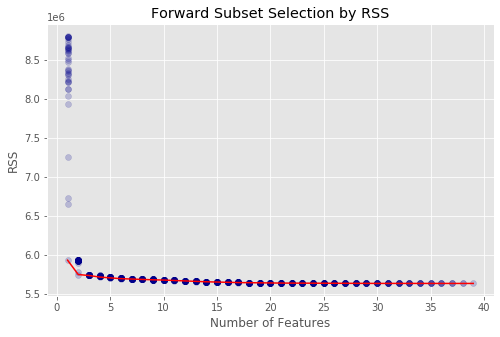

In [0]:
forward_model, stat_df = forwardss(features, X, Y, 'CV')
print(stat_df.head(20))
print(forward_model)

fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(1,1,1)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.scatter(stat_df['num_features'],stat_df['RSS'], alpha = .2, color = 'darkblue')
ax.set_xlabel('Number of Features')
ax.set_ylabel('RSS')
ax.set_title('Forward Subset Selection by RSS')
ax.plot(stat_df['num_features'], stat_df['min_RSS'], color = 'r', label = 'Best Subset')

plt.show()

In [0]:
# Backward Subset Selection Algorithm
def backwardss(features, X, Y, criterion="C_p"):
  RSS_list = []
  feature_list, num_features = [], []
  model_list = []
  best_features = features.copy()
  k = len(features)
  # Start with all features and iterate backwards
  for i in range(k, 0, -1):
    print("Currently on {} features".format(i))
    # Get remaining features and smallest RSS for this iteration
    remaining_features = best_features.copy()
    best_RSS = np.inf
    # Go through all possible removals of one feature
    for feature in combinations(remaining_features, 1):
      feature_combo = remaining_features.copy()
      feature_combo.remove(feature[0])
      X_curr = X[feature_combo]
      model_curr, RSS_curr = fit_model(X_curr,Y)
      RSS_list.append(RSS_curr)
      feature_list.append(feature_combo)
      num_features.append(len(feature_combo))
      # If this particular combination is better than all the previous ones,
      # set it as our best combination
      model_list.append(model_curr)
      if RSS_curr < best_RSS:
        best_RSS = RSS_curr
        best_features = feature_combo

  stat_df = pd.DataFrame({'num_features' : num_features, 'RSS' : RSS_list, 'features' : feature_list, 'model' : model_list})
  stat_df['min_RSS'] = stat_df.groupby('num_features')['RSS'].transform(min)

  m = len(Y)
  k = len(features)
  sigma_hat_squared = 1/(m - k - 1)*min(stat_df['RSS'])
  
  stat_df['C_p'] = (1/m) * (stat_df['RSS'] + 2 * stat_df['num_features'] * sigma_hat_squared)
  stat_df['AIC'] = (1/m * sigma_hat_squared) * (stat_df['RSS'] + np.log(m) * stat_df['num_features'] * sigma_hat_squared)
  stat_df['BIC'] = (1/(m*sigma_hat_squared)) * (stat_df['RSS'] +  np.log(m) * stat_df['num_features'] * sigma_hat_squared)

  idx_num_features_min_rss = stat_df.groupby(['num_features'])['RSS'].idxmin()
  backward_model_df = stat_df.loc[idx_num_features_min_rss, :].reset_index()

  backward_model_df['CV'] = backward_model_df['features'].apply(k_fold_cross_val, args=(X,Y,5,))
  
  print(backward_model_df)

  backward_model = backward_model_df.loc[backward_model_df[criterion].idxmin(), :]
  
  stat_df = stat_df.sort_values(by =['num_features', 'RSS'])

  return backward_model, stat_df

Currently on 39 features


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Currently on 38 features
Currently on 37 features
Currently on 36 features
Currently on 35 features
Currently on 34 features
Currently on 33 features
Currently on 32 features
Currently on 31 features
Currently on 30 features
Currently on 29 features
Currently on 28 features
Currently on 27 features
Currently on 26 features
Currently on 25 features
Currently on 24 features
Currently on 23 features
Currently on 22 features
Currently on 21 features
Currently on 20 features
Currently on 19 features
Currently on 18 features
Currently on 17 features
Currently on 16 features
Currently on 15 features
Currently on 14 features
Currently on 13 features
Currently on 12 features
Currently on 11 features
Currently on 10 features
Currently on 9 features
Currently on 8 features
Currently on 7 features
Currently on 6 features
Currently on 5 features
Currently on 4 features
Currently on 3 features
Currently on 2 features
Currently on 1 features
Applying 5-fold to 0 features...
Applying 5-fold to 1 featu

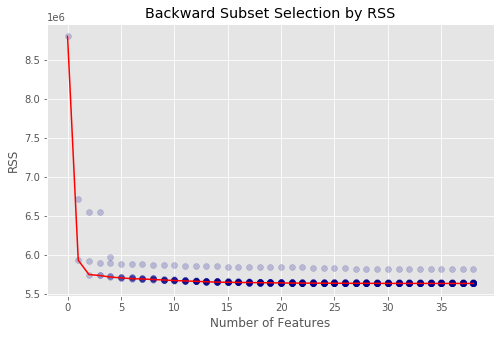

In [0]:
backward_model, stat_df = backwardss(features, X, Y, 'BIC')
print(stat_df.head(20))
print(backward_model)

fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(1,1,1)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.scatter(stat_df['num_features'],stat_df['RSS'], alpha = .2, color = 'darkblue')
ax.set_xlabel('Number of Features')
ax.set_ylabel('RSS')
ax.set_title('Backward Subset Selection by RSS')
ax.plot(stat_df['num_features'], stat_df['min_RSS'], color = 'r', label = 'Best Subset')

plt.show()